In [1]:
import numpy as np
from statsmodels.tsa.stattools import adfuller,kpss
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline     
import torch
import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.lpcmci import LPCMCI
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from statsmodels.tools.sm_exceptions import InterpolationWarning
import warnings
from tigramite.lpcmci import LPCMCI
import seaborn as sns
# from tigramite.independence_tests.gpdc import GPDC
# from tigramite.independence_tests.cmiknn import CMIknn
# from tigramite.independence_tests.cmisymb import CMIsymb

Load Data, Handle Missingness:

In [8]:
data = torch.load(f"/home/gnicolaou/tigramite/tutorials/causal_discovery/combined_tensor.pt")
N = data.shape[1]
dat = data.numpy()
modified_columns = []
for col in range(dat.shape[1]):
    column_data = dat[:, col]
    
    # insert 999 values between every 144 elements
    modified_column = np.insert(column_data, np.arange(144, column_data.size, 144), None)
    
    # append the modified column to the list
    modified_columns.append(modified_column)

modified_data = np.column_stack(modified_columns)

#print(modified_data)
data = pd.DataFrame(modified_data)
data.to_csv('data.csv', index=False)

In [2]:

# Number of observed variables
N = data.shape[1]
dat = data.numpy()

# empty list to store the modified columns to separate trajectories
modified_columns = []

for col in range(dat.shape[1]):
    column_data = dat[:, col]
    
    # insert 999 values between every 144 elements
    modified_column = np.insert(column_data, np.arange(144, column_data.size, 144), 999)
    
    # append the modified column to the list
    modified_columns.append(modified_column)

modified_data = np.column_stack(modified_columns)

In [3]:

dat = modified_data # handle missingness
n_a_n = np.isnan(dat).any(axis=1)
dat[n_a_n] = 999
var_names = ['Nd','Pr','sst','lts','fth','ws','div','cf']
dataframe = pp.DataFrame(dat, var_names=var_names, missing_flag = 999)
#tp.plot_timeseries(dataframe); plt.show()

Things we need to check:
1. Stationarity of Each Time Series
2. Only Lagged Dependencies
3. All of the Causal Assumptions
4. Pick a conditional independence test and make sure the data satisfies those assumptions
5. Causal Stationarity


First, we check Stationarity using Augmented Dickey-Fuller Test and Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [17]:
warnings.simplefilter('ignore', InterpolationWarning)
data = pd.DataFrame(data)
pval = .05
columns = ['ADF', 'KPSS']
output = pd.DataFrame(columns=columns)
for i in range(data.shape[1]):
    val = []
    ts_data = dat[i]
    if adfuller(ts_data)[1] < pval:
        val.append('Stationary')
    else:
        val.append('Non-Stationary')
    if kpss(ts_data)[1] > pval:
        val.append('Stationary')
    else:
        val.append('Non-Stationary')
    output.loc[len(output)] = val
print(output)


          ADF        KPSS
0  Stationary  Stationary
1  Stationary  Stationary
2  Stationary  Stationary
3  Stationary  Stationary
4  Stationary  Stationary
5  Stationary  Stationary
6  Stationary  Stationary
7  Stationary  Stationary


Lagged Dependencies

Checking if dependencies seem linear and gaussian.


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 10


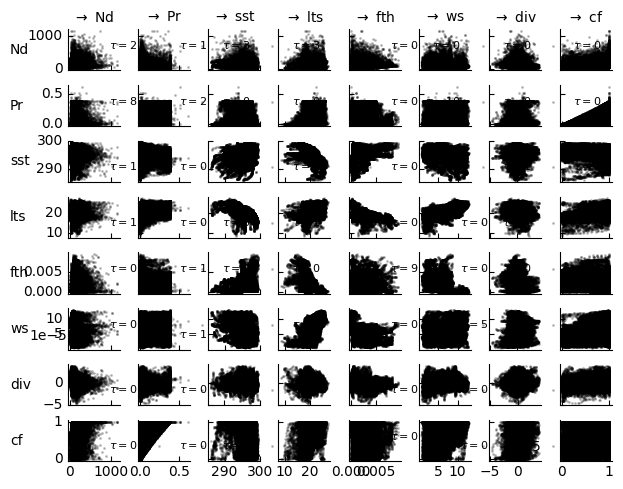

In [4]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)
correlations = pcmci.get_lagged_dependencies(tau_max=10, val_only=True)['val_matrix']
tp.plot_scatterplots(dataframe=dataframe, add_scatterplot_args={'matrix_lags':np.argmax(np.abs(correlations), axis=2)}); plt.show()

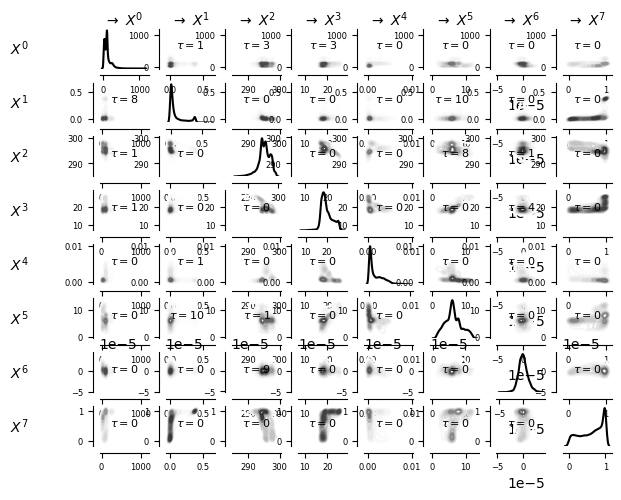

In [9]:
tp.plot_densityplots(dataframe=dataframe, add_densityplot_args={'matrix_lags':np.argmax(np.abs(correlations), axis=2)})
plt.show()

Plots indicate that it is neither linear nor gaussian, so 

In [5]:
from tigramite.independence_tests.gpdc import GPDC
gpdc = GPDC(significance='analytic', gp_params=None)
pcmci_gpdc = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=gpdc,
    verbosity=0)

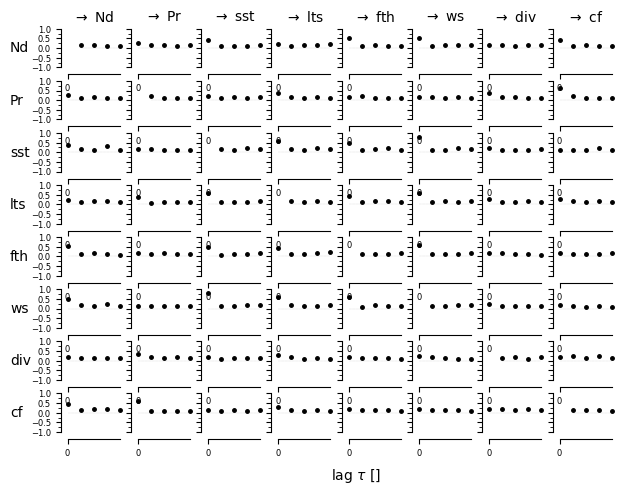

In [6]:
correlations = pcmci_gpdc.get_lagged_dependencies(tau_max=4, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':.5}); plt.show()

We pick time lag = 1 because that is when it tapers to 0

In [18]:
link_assumptions = {j:{(i, -tau):'' for i in range(8) for tau in range(2) if (i, -tau) != (j, 0)} 
                            for j in range(8)}

link_assumptions[0][(1, 0)] = '<?-' #Nd is an ancestor of P
link_assumptions[1][(0, 0)] = '-?>'
link_assumptions[7][(1, 0)] = '<?-'# CF is an ancestor of precipitation
link_assumptions[1][(7, 0)] = '-?>'
link_assumptions[0][(0, -1)] = '-?>' #Nd at lag t-1 is an ancestor of Nd
link_assumptions[0][(1, -1)] = '-?>' #P at lag t-1 is an ancestor of Nd
link_assumptions[7][(1, -1)] = '-?>' #P at lag t-1 is an ancestor of CF
link_assumptions[7][(0, -1)] = 'o?>' #Nd at lag t-1 is an ancestor of CF
link_assumptions[1][(0, -1)] = 'o?>' #Nd at lag t-1 is an ancestor of P
link_assumptions[1][(7, -1)] = 'o?>' #CF at lag -1 is an ancestor of P
link_assumptions[7][(7, -1)] = 'o?>' #CF at lag t-1 is an ancestor of CF
for j in range(2,7): 
    link_assumptions[j][(0, 0)] = '<?-' #meterological variables are ancestor of aerosol
    link_assumptions[0][(j, 0)] = '-?>'
    link_assumptions[j][(7, 0)] = '<?-' #meteorological variables are ancestor of cloud fraction
    link_assumptions[7][(j, 0)] = '-?>'
    link_assumptions[j][(j, -1)] = '-?>' #meterological variables at lag t-1 is an ancestor of meteorological variables
    for k in range(2,7):
        if (j != k):
            link_assumptions[j][k,0] = 'o?o' #all meteorology variables are contemporaneously linked
            link_assumptions[k][j,0] = 'o?o'
            link_assumptions[j][k,-1] = 'o?>' #all meteorology variables at lag t-1 is an ancestor of eachother
            link_assumptions[k][j,-1] = 'o?>' 

print(link_assumptions)

{0: {(0, -1): '-?>', (1, 0): '<?-', (1, -1): '-?>', (2, 0): '-?>', (2, -1): '', (3, 0): '-?>', (3, -1): '', (4, 0): '-?>', (4, -1): '', (5, 0): '-?>', (5, -1): '', (6, 0): '-?>', (6, -1): '', (7, 0): '', (7, -1): ''}, 1: {(0, 0): '-?>', (0, -1): 'o?>', (1, -1): '', (2, 0): '', (2, -1): '', (3, 0): '', (3, -1): '', (4, 0): '', (4, -1): '', (5, 0): '', (5, -1): '', (6, 0): '', (6, -1): '', (7, 0): '-?>', (7, -1): 'o?>'}, 2: {(0, 0): '<?-', (0, -1): '', (1, 0): '', (1, -1): '', (2, -1): '-?>', (3, 0): 'o?o', (3, -1): 'o?>', (4, 0): 'o?o', (4, -1): 'o?>', (5, 0): 'o?o', (5, -1): 'o?>', (6, 0): 'o?o', (6, -1): 'o?>', (7, 0): '<?-', (7, -1): ''}, 3: {(0, 0): '<?-', (0, -1): '', (1, 0): '', (1, -1): '', (2, 0): 'o?o', (2, -1): 'o?>', (3, -1): '-?>', (4, 0): 'o?o', (4, -1): 'o?>', (5, 0): 'o?o', (5, -1): 'o?>', (6, 0): 'o?o', (6, -1): 'o?>', (7, 0): '<?-', (7, -1): ''}, 4: {(0, 0): '<?-', (0, -1): '', (1, 0): '', (1, -1): '', (2, 0): 'o?o', (2, -1): 'o?>', (3, 0): 'o?o', (3, -1): 'o?>', (4, -1

[[['' '-->' '']
  ['-->' '-->' '']
  ['-->' '-->' '']
  ['-->' '-->' '']
  ['-->' '-->' '']
  ['-->' '-->' '']
  ['-->' '-->' '']
  ['-->' '-->' '']]

 [['<--' '-->' '']
  ['' '-->' '']
  ['-->' '-->' '']
  ['-->' '-->' '']
  ['-->' '-->' '']
  ['-->' '-->' '']
  ['-->' '-->' '']
  ['-->' '-->' '']]

 [['<--' '-->' '']
  ['<--' '-->' '']
  ['' '-->' '']
  ['-->' '-->' '']
  ['-->' '-->' '']
  ['-->' '-->' '']
  ['-->' '-->' '']
  ['-->' '-->' '']]

 [['<--' '-->' '']
  ['<--' '-->' '']
  ['<--' '-->' '']
  ['' '-->' '']
  ['-->' '-->' '']
  ['-->' '-->' '']
  ['-->' '-->' '']
  ['-->' '-->' '']]

 [['<--' '-->' '']
  ['<--' '-->' '']
  ['<--' '-->' '']
  ['<--' '-->' '']
  ['' '-->' '']
  ['-->' '-->' '']
  ['-->' '-->' '']
  ['-->' '-->' '']]

 [['<--' '-->' '']
  ['<--' '-->' '']
  ['<--' '-->' '']
  ['<--' '-->' '']
  ['<--' '-->' '']
  ['' '-->' '']
  ['-->' '-->' '']
  ['-->' '-->' '']]

 [['<--' '-->' '']
  ['<--' '-->' '']
  ['<--' '-->' '']
  ['<--' '-->' '']
  ['<--' '-->' '']

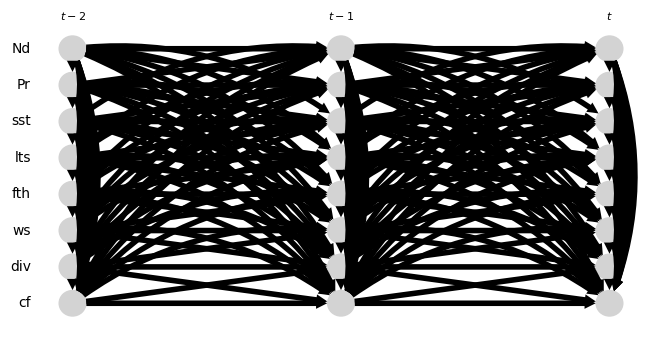

In [72]:
from tigramite.causal_effects import CausalEffects
graph = CausalEffects.get_graph_from_dict(link_assumptions, tau_max=2)
print(graph)
tp.plot_time_series_graph(graph = graph,
        var_names=var_names, 
        figsize = (8, 4),
        ); plt.show()

(<Figure size 640x480 with 1 Axes>, <Axes: >)

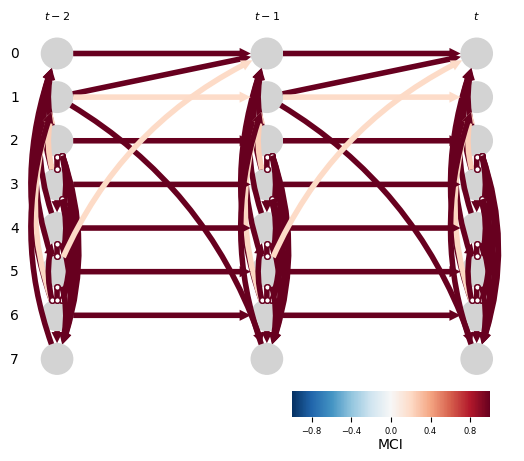

In [76]:
pcmci_gpdc = LPCMCI(
    dataframe=dataframe, 
    cond_ind_test=gpdc,
    verbosity=0)
results = pcmci_gpdc.run_lpcmci(tau_max=2, pc_alpha=0.05, link_assumptions = link_assumptions)
tp.plot_time_series_graph(graph=results['graph'],
                          val_matrix=results['val_matrix'])

TESTING BOOTSTRAPPING

In [9]:
data = torch.load(f"/home/gnicolaou/tigramite/tutorials/causal_discovery/combined_tensor.pt")
N = data.shape[1]
dat = data.numpy()
modified_columns = []
for col in range(dat.shape[1]):
    column_data = dat[:, col]
    
    # insert 999 values between every 144 elements
    modified_column = np.insert(column_data, np.arange(144, column_data.size, 144), None)
    
    # append the modified column to the list
    modified_columns.append(modified_column)

modified_data = np.column_stack(modified_columns)
N = data.shape[1]
dat = data.numpy()

# empty list to store the modified columns to separate trajectories
modified_columns = []

for col in range(dat.shape[1]):
    column_data = dat[:, col]
    
    # insert 999 values between every 144 elements
    modified_column = np.insert(column_data, np.arange(144, column_data.size, 144), 999)
    
    # append the modified column to the list
    modified_columns.append(modified_column)

modified_data = np.column_stack(modified_columns)

dat = modified_data # handle missingness
n_a_n = np.isnan(dat).any(axis=1)
dat[n_a_n] = 999
var_names = ['Nd','Pr','sst','lts','fth','ws','div','cf']
dataframe = pp.DataFrame(dat, var_names=var_names, missing_flag = 999)

In [25]:
print(dataframe)

In [17]:
link_assumptions2 = {j:{(i, -tau):'' for i in range(8) for tau in range(2) if (i, -tau) != (j, 0)} 
                            for j in range(8)}
#link_assumptions2[0][(1, 0)] = '<--' #Nd is an ancestor of P
#link_assumptions2[1][(0, 0)] = '-->'
link_assumptions2[7][(1, 0)] = '<--'# CF is an ancestor of precipitation
link_assumptions2[1][(7, 0)] = '-->'
link_assumptions2[0][(0, -1)] = '-->' #Nd at lag t-1 is an ancestor of Nd
link_assumptions2[0][(1, -1)] = '-->' #P at lag t-1 is an ancestor of Nd
link_assumptions2[7][(1, -1)] = '-->' #P at lag t-1 is an ancestor of CF
link_assumptions2[7][(0, -1)] = '-->' #Nd at lag t-1 is an ancestor of CF
link_assumptions2[1][(0, -1)] = '-->' #Nd at lag t-1 is an ancestor of P
link_assumptions2[1][(7, -1)] = '-->' #CF at lag -1 is an ancestor of P
link_assumptions2[7][(7, -1)] = '-->' #CF at lag t-1 is an ancestor of CF

In [18]:
parcorr = ParCorr(significance='analytic')
link_assumptions = {j:{(i, -tau):'' for i in range(8) for tau in range(2) if (i, -tau) != (j, 0)} 
                            for j in range(8)}

link_assumptions[0][(1, 0)] = '<?-' #Nd is an ancestor of P
link_assumptions[1][(0, 0)] = '-?>'
link_assumptions[7][(1, 0)] = '<?-'# CF is an ancestor of precipitation
link_assumptions[1][(7, 0)] = '-?>'
link_assumptions[0][(0, -1)] = '-?>' #Nd at lag t-1 is an ancestor of Nd
link_assumptions[0][(1, -1)] = '-?>' #P at lag t-1 is an ancestor of Nd
link_assumptions[7][(1, -1)] = '-?>' #P at lag t-1 is an ancestor of CF
link_assumptions[7][(0, -1)] = 'o?>' #Nd at lag t-1 is an ancestor of CF
link_assumptions[1][(0, -1)] = 'o?>' #Nd at lag t-1 is an ancestor of P
link_assumptions[1][(7, -1)] = 'o?>' #CF at lag -1 is an ancestor of P
link_assumptions[7][(7, -1)] = 'o?>' #CF at lag t-1 is an ancestor of CF
for j in range(2,7): 
    link_assumptions[j][(0, 0)] = '<?-' #meterological variables are ancestor of aerosol
    link_assumptions[0][(j, 0)] = '-?>'
    link_assumptions[j][(7, 0)] = '<?-' #meteorological variables are ancestor of cloud fraction
    link_assumptions[7][(j, 0)] = '-?>'
pcmci = LPCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=0)
results = pcmci.run_lpcmci(tau_max=2, pc_alpha=.05, link_assumptions = link_assumptions2)
print(results['graph'])

[[['' '-->' '']
  ['' '-->' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '-->' '']]

 [['' '-->' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['<--' '-->' '']]

 [['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']]

 [['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']]

 [['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']]

 [['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']]

 [['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']]

 [['' '' '']
  ['-->' '-->' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '' '']
  ['' '-->' '']]]


In [26]:
new_arr = np.zeros_like(results['graph'], dtype=int)

# Set 1 for non-empty strings, 0 for empty strings
new_arr[results['graph'] != ''] = 1

#print(new_arr)
new = (new_arr + new_arr)/4
print (new)

[[[0.  0.5 0. ]
  [0.  0.5 0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.5 0. ]]

 [[0.  0.5 0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.5 0.5 0. ]]

 [[0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]]

 [[0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]]

 [[0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]]

 [[0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]]

 [[0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]]

 [[0.  0.  0. ]
  [0.5 0.5 0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0. 

(<Figure size 640x480 with 1 Axes>, <Axes: >)

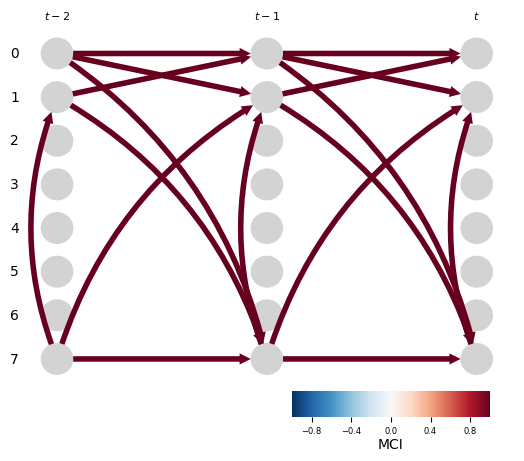

In [19]:
tp.plot_time_series_graph(graph=results['graph'],
                          val_matrix=results['val_matrix'])